# Figure 5

In [1]:
# Import packages.
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# Print version numbers.
print('matplotlib', matplotlib.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)

matplotlib 3.5.2
numpy 1.22.3
pandas 1.4.2


In [2]:
# Intialize the matplolib styling.
plt.rcParams.update({
    'figure.constrained_layout.use': True,
    'figure.facecolor': 'white',
    'font.family': 'serif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
})

In [3]:
# Import the TGP meta data.
tgp_df = pd.read_csv(
    './data/tgp_mod.txt', sep='\t',
    names=['IND', 'POP', 'SUPERPOP'],
)
# Intialize the tgp pop list.
tgp_pop_list = [
    'LWK', 'GWD', 'MSL', 'ESN', 'YRI', # AFR.
    'BEB', 'STU', 'ITU', 'PJL', 'GIH', # SAS.
    'CHB', 'KHV', 'CHS', 'JPT', 'CDX', # EAS.    
    'TSI', 'CEU', 'IBS', 'GBR', 'FIN', # EUR.
    'PEL', 'MXL', 'CLM', 'PUR', # AMR.
]
# Intialize dictionaries of haplotype identity.
het_hom_rec_int_72kb = {
    'HET': np.loadtxt('./data/72kb_all_het_int_idx.csv', delimiter=',', dtype=int),
    'HOM': np.loadtxt('./data/72kb_all_hom_int_idx.csv', delimiter=',', dtype=int),
    'REC': np.loadtxt('./data/72kb_all_rec_int_idx.csv', delimiter=',', dtype=int),
}
# Load in the repeats dataframe.
repeats_df = pd.read_csv('./data/hg38_muc19_short_read_repeats.csv')

In [4]:
# Intialize lists to store the results per population.
pop_repeats_72kb = []
hum_repeats_72kb = []
pop_het_mask_72kb = []
pop_hom_mask_72kb = []
pop_rec_mask_72kb = []
pop_den_mask_72kb = []
# For every population...
for pop in tgp_pop_list:
    # Subset the data frames.
    tgp_sub = tgp_df[tgp_df['POP'] == pop]
    # Construct a mask for the Denisovan-like individuals.
    het_mask = np.isin(tgp_sub.index.values, het_hom_rec_int_72kb['HET'])
    hom_mask = np.isin(tgp_sub.index.values, het_hom_rec_int_72kb['HOM'])
    rec_mask = np.isin(tgp_sub.index.values, het_hom_rec_int_72kb['REC'])
    den_mask = np.logical_or.reduce((het_mask, hom_mask, rec_mask))
    # Subset and extract the individuals and repeats from the repeat data.
    repeats_sub = repeats_df[repeats_df['Population'] == pop]
    repeat_inds = repeats_sub['Individual'].values
    repeat_counts = repeats_sub['Repeat Counts'].values
    # Intialize a list of repeat counts.
    pop_counts = []
    # For every individual...
    for ind in tgp_sub['IND'].values:
        # Determine the index of the individual in the repeat data.
        idx = np.where(repeat_inds == ind)[0]
        # If the individual from the hg38 dataset isn't in our dataset.
        if idx.size == 1:
            # Append the results.
            pop_counts.append(repeat_counts[idx][0])
        # Else...
        else:
            # Append the results with missing data.
            pop_counts.append(np.nan)
    # Append the lists for plotting.
    pop_repeats_72kb.append(np.array(pop_counts))
    hum_repeats_72kb.append(np.array(pop_counts)[~den_mask])
    pop_het_mask_72kb.append(het_mask)
    pop_hom_mask_72kb.append(hom_mask)
    pop_rec_mask_72kb.append(rec_mask)
    pop_den_mask_72kb.append(den_mask)
# Intialize a list to store human repeat counts.
hum_clean_repeats_72kb = []
# For every population.
for pop in hum_repeats_72kb:
    # Determine the indicies for which we don't have data for.
    nan_mask = np.isnan(pop)
    # Append the results.
    hum_clean_repeats_72kb.append(pop[~nan_mask])

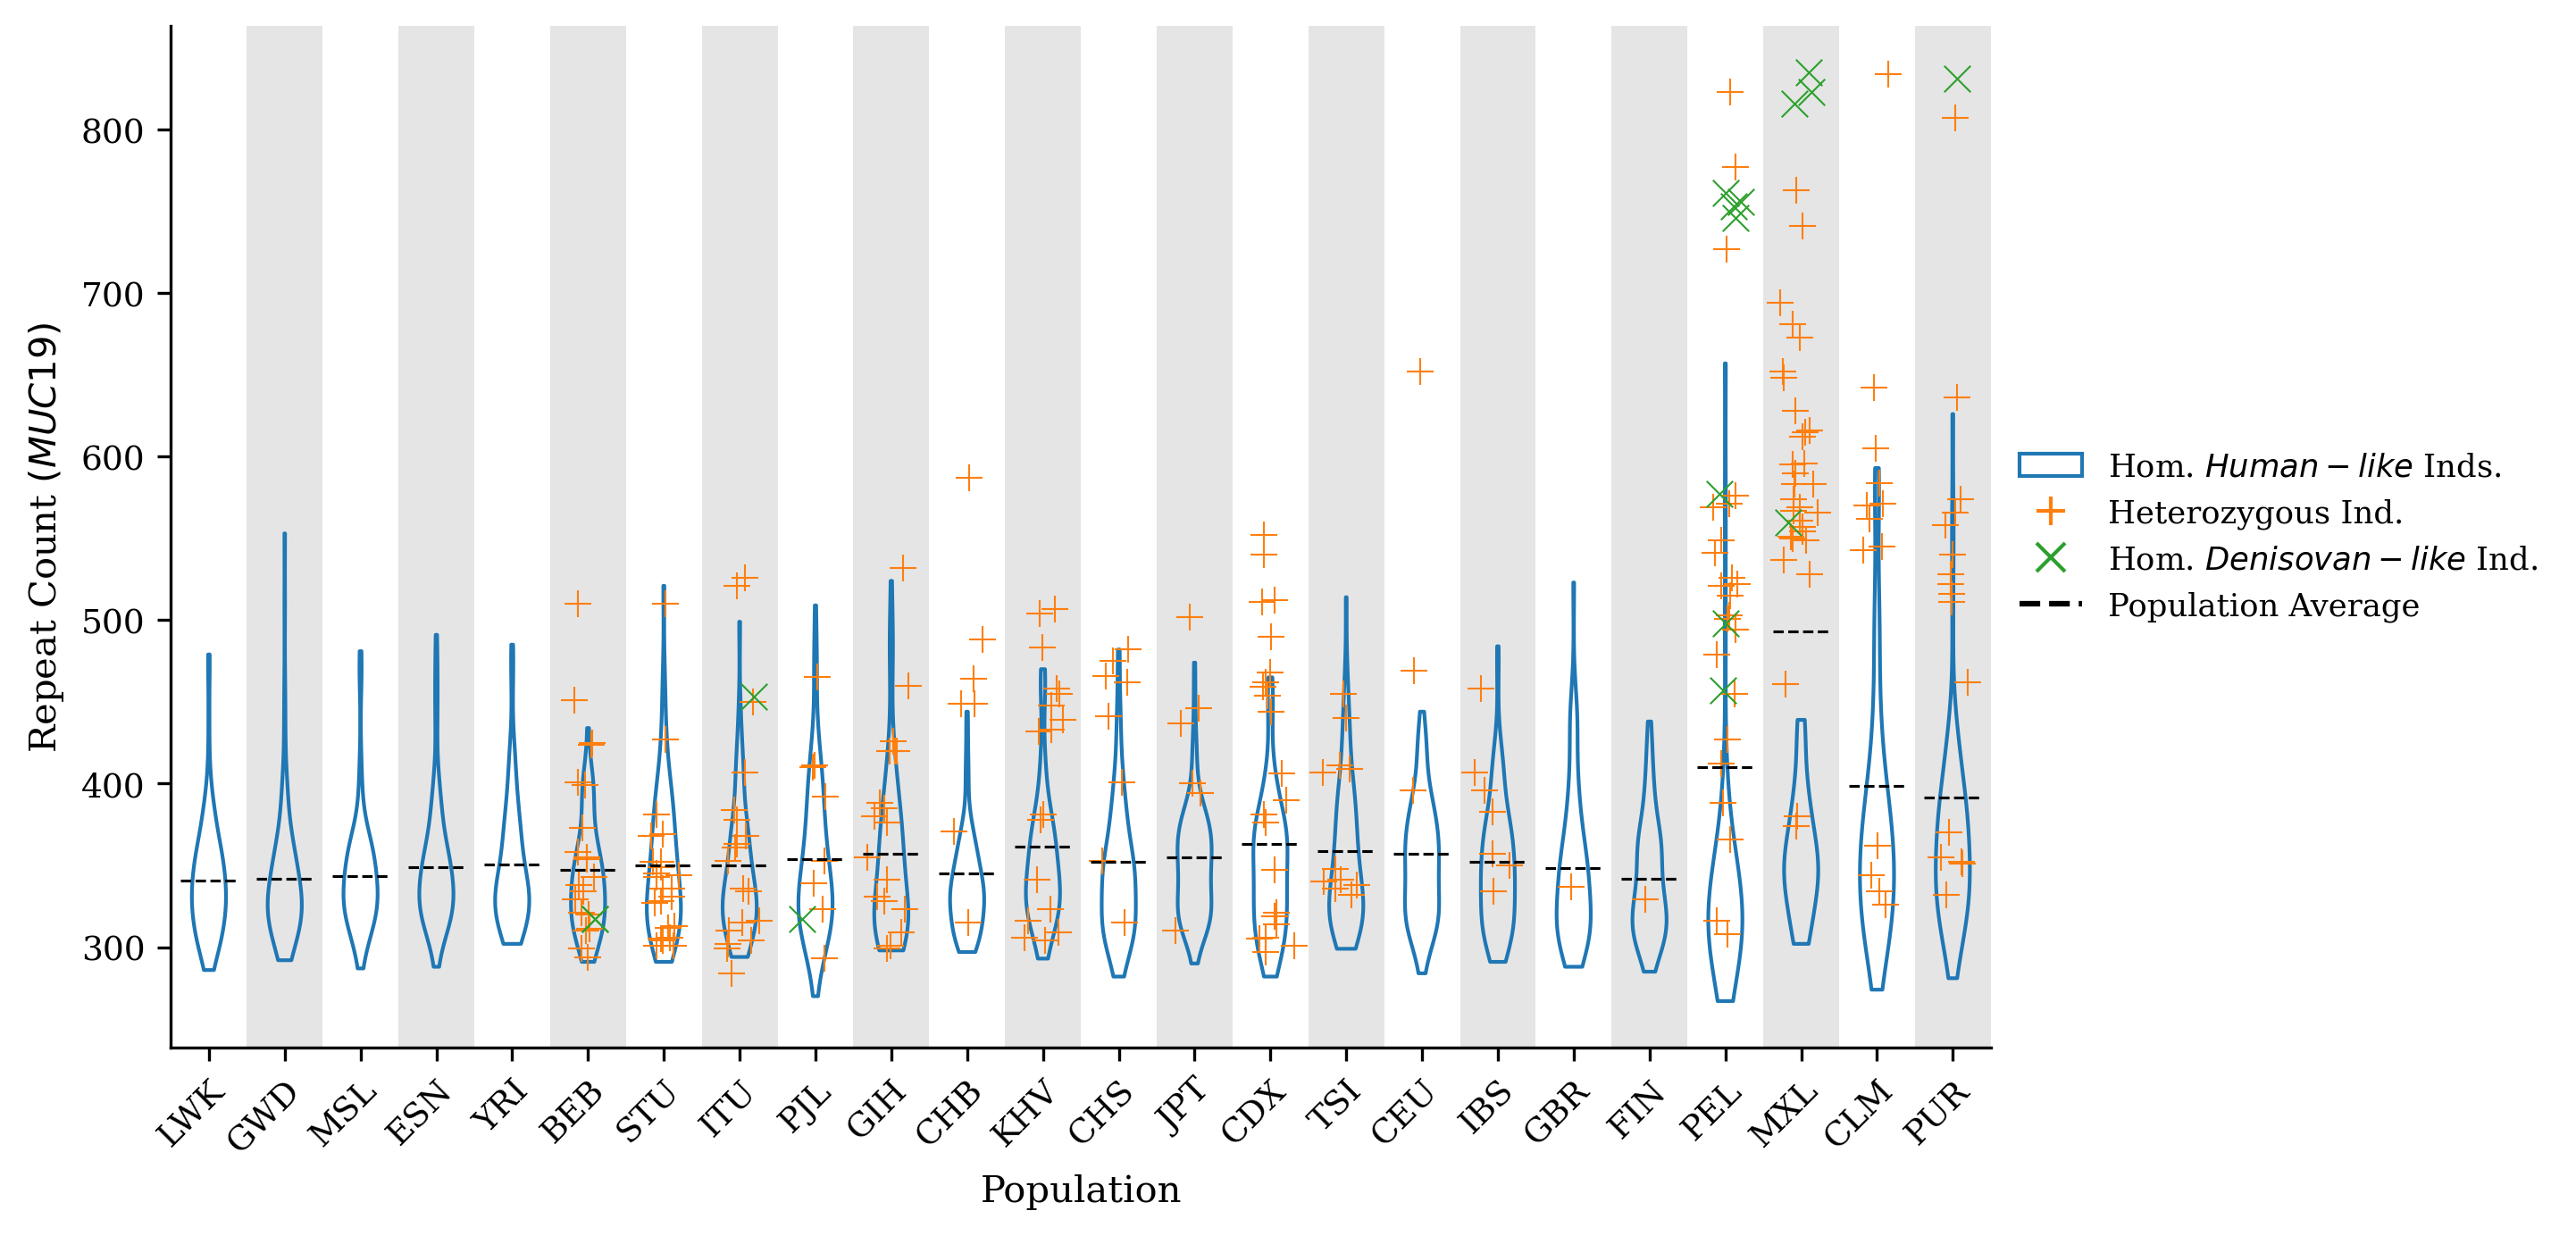

In [5]:
# Intialize the positions to plot.
repeat_pos = np.arange(0, len(tgp_pop_list)*2, 2)
# Intialize a function for plotting the alternating background.
def alt_bands(ax=None):
    locs = np.arange(2, len(tgp_pop_list)*2, 4)
    for loc in locs:
        ax.axvspan(loc-1, loc+1, facecolor='black', alpha=0.1)
# Intialize the figure.
fig = plt.figure(
    figsize=(9.5, 4.5), dpi=300,
)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the alternating bands
alt_bands(ax)
# Plot the human-like repeat counts.
vp = ax.violinplot(
    hum_clean_repeats_72kb, repeat_pos,
    vert=True, showextrema=False,
    showmeans=False, widths=0.9,
)
# Adjust the violin plots to only show the outline.
for pc in vp['bodies']:
    pc.set_facecolor('none')
    pc.set_edgecolor('tab:blue')
    pc.set_alpha(1)
# For every population...
for idx in range(len(tgp_pop_list)):
    # Extract the positions.
    x_pos = repeat_pos[idx]
    # Compute the mean.
    repeat_mean = np.nanmean(pop_repeats_72kb[idx])
    # Plot the mean.
    ax.hlines(
        repeat_mean, x_pos-0.75, x_pos+0.75,
        colors='black', linestyle='dashed', linewidths=0.75,
    )
# Set the index counter.
idx_counter = 0
# For every x-axis tick.
for i in repeat_pos:
    # Grab the data points.
    y = pop_repeats_72kb[idx_counter]
    # Add some jitter to the x-axis.
    x_hets = np.random.normal(i, 0.25, size=len(y[pop_het_mask_72kb[idx_counter]]))
    x_homs = np.random.normal(i, 0.25, size=len(y[pop_hom_mask_72kb[idx_counter]]))
    # Plot the points!
    ax.scatter(
        x_hets, np.sort(y[pop_het_mask_72kb[idx_counter]]),
        color='tab:orange', marker='+', s=50, linewidths=0.5,
    )
    ax.scatter(
        x_homs, np.sort(y[pop_hom_mask_72kb[idx_counter]]),
        color='tab:green', marker='x', s=50, linewidths=0.5,
    )
    # Move the index counter forward.
    idx_counter += 1
# Configure the legend.
legend_elements = [
    Patch(facecolor='none', edgecolor='tab:blue', label=r'Hom. $Human-like$ Inds.'),
    Line2D([0], [0], marker='+', color='tab:orange', linestyle='none', markersize=7.5, label='Heterozygous Ind.'),
    Line2D([0], [0], marker='x', color='tab:green', linestyle='none', markersize=7.5, label=r'Hom. $Denisovan-like$ Ind.'),
    Line2D([0], [0], color='black', linestyle='dashed', label='Population Average'),
]
# Add a figure lgend.
ax.legend(
    handles=legend_elements, loc='center left',
    bbox_to_anchor=(1.0, 0.5), frameon=False,
    fontsize=8.5,
)
# Set the axes labels.
plt.xlabel('Population', size=10)
plt.ylabel(r'Repeat Count $\left( MUC19 \right)$', size=10)
# Set the x-axis tick positions and labels.
ax.set_xticks(repeat_pos)
ax.set_xticklabels(
    tgp_pop_list, rotation=45,
    ha='right', rotation_mode='anchor',
)
# Set the x-axis tick positions and labels.
ax.set_xlim(-1, (len(tgp_pop_list)*2)-1)
ax.tick_params(axis='y', labelsize=9)
ax.tick_params(axis='x', labelsize=9)
# Export the plot.
plt.savefig(
    './figures/figure_5.png', format='png',
    facecolor='white', bbox_inches='tight', dpi=500,
)
# Show the plot.
plt.show()